In [1]:
import numpy as np
import matplotlib.pyplot as plt
import geone
import geone.covModel as gcm
import scipy
import numba 
from numba import jit

In [ ]:
@jit()
def merge_tensorial(k1xx, k1yy, k1xy, k2xx, k2yy, k2xy, w1, w2):
    Kxx = (w1 + w2) * k1xx * k2xx / (w1 * k2xx + w2 * k1xx)
    Kyy = 1 / (w1 + w2) * (w1 * k1yy + w2 * k2yy - w1 * w2 * (k1xy - k2xy) ** 2 / (w1 * k2xx + w2 * k1xx))
    Kxy = (w2 * k1xx * k2xy + w1 * k2xx * k1xy ) / (w2 * k1xx + w1 * k2xx)
    return Kxx, Kyy, Kxy

In [2]:
# create functions to compute the equivalent permeability of a 2D field
# This is done by computing the arithmetic mean / or the harmonic mean in the x and y directions sequentially until the final value is obtained

@jit()
def hmean(v1, v2, w1=1, w2=1):
    return (w1 + w2) / (w1 / v1 + w2 / v2)

@jit()
def mean(v1, v2, w1=1, w2=1):
    return (v1 * w1 + v2 * w2) / (w1 + w2)

def f(a, dx=None, dy=None, direction="x", type="series"):

    """
    Function to operate a mean row or column wise by pairs of rows or columns
    """

    w1 = 1
    w2 = 1
    new_dx = None
    new_dy = None
    # select the vectors
    if (direction == "x" and type == "parallel") or (direction == "y" and type == "series"):

        v1 = a[::2]
        v2 = a[1::2]
        if dy is not None:
            w1 = dy[::2]
            w2 = dy[1::2]
            new_dy = w1 + w2
            new_dx = dx[::2]

    if (direction == "x" and type == "series") or (direction == "y" and type == "parallel"):

        v1 = a[:, ::2]
        v2 = a[:, 1::2]
        if dx is not None:
            w1 = dx[:, ::2]
            w2 = dx[:, 1::2]
            new_dx = w1 + w2
            new_dy = dy[:, ::2]

    # merge
    if type == "parallel":
        return mean(v1, v2, w1, w2), new_dx, new_dy
    elif type == "series":
        return hmean(v1, v2, w1, w2), new_dx, new_dy

def test_f():

    """
    Test the function f
    """

    a = np.array([[0.2707579 , 0.67406735], 
                  [0.04264607, 0.17996007]])

    assert np.allclose(f(a, direction="x", type="parallel")[0], np.array([[0.15670199, 0.42701371]]))
    assert np.allclose(f(a, direction="x", type="series")[0], np.array([[0.38633401], [0.06895219]]))
    assert np.allclose(f(a, direction="y", type="parallel")[0], np.array([[0.47241263], [0.11130307]]))
    assert np.allclose(f(a, direction="y", type="series")[0], np.array([[0.07368612, 0.28407801]]))

    print("Test passed")

In [3]:
test_f()

Test passed


In [4]:
a = np.array([[1, 2, 3, 4], [5, 6, 7, 8], [9, 10, 11, 12], [13, 14, 15, 16]])
dx = np.ones((4, 4))
dy = np.ones((4, 4))
dx[:, -1] = .5
f(a, dx=dx, dy=dy, direction="y", type="parallel")

(array([[ 1.5       ,  3.33333333],
        [ 5.5       ,  7.33333333],
        [ 9.5       , 11.33333333],
        [13.5       , 15.33333333]]),
 array([[2. , 1.5],
        [2. , 1.5],
        [2. , 1.5],
        [2. , 1.5]]),
 array([[1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.]]))

In [42]:


def find_c(k_field, dx=None, dy=None, direction="x", first_type="series"):

    k_field_copy = k_field.copy()

    if first_type == "series":
        o = 1
    else:
        o = 2

    # if dx and dy are not provided, set them to 1
    if dx is None:
        dx = np.ones(k_field.shape)
    if dy is None:
        dy = np.ones(k_field.shape)

    # if dx and dy are provided as a scalar, set them to an array of the same shape as k_field
    if isinstance(dx, (int, float)):
        dx = np.ones(k_field.shape) * dx
    if isinstance(dy, (int, float)):
        dy = np.ones(k_field.shape) * dy

    # loop until the final value is obtained
    while k_field_copy.flatten().shape[0] > 1:
        # print(k_field_copy) 
        # print("\n", dx, "\n", dy)
        # print("\n", k_field_copy)
        if o % 2 == 0 and ((direction == "x" and k_field_copy.shape[0]>1) or (direction == "y" and k_field_copy.shape[1]>1)):  # operate an arithmetic mean
            
            # remove the last row or column if the number of rows or columns is odd
            rm_row = None
            rm_col = None
            rm_dx = None
            rm_dy = None
            if direction == "x" and k_field_copy.shape[0] % 2 == 1:
                # remove the last row if the number of rows is odd
                rm_row = k_field_copy[-1, :]
                k_field_copy = k_field_copy[:-1, :]
                rm_dx = dx[-1, :]
                rm_dy = dy[-1, :]
                dx = dx[:-1, :]
                dy = dy[:-1, :]
            elif direction == "y" and k_field_copy.shape[1] % 2 == 1:
                # remove the last column if the number of columns is odd
                rm_col = k_field_copy[:, -1]
                k_field_copy = k_field_copy[:, :-1]
                rm_dx = dx[:, -1]
                rm_dy = dy[:, -1]
                dx = dx[:, :-1]
                dy = dy[:, :-1]

            # compute the mean
            k_field_copy, dx, dy = f(k_field_copy, dx, dy, type="parallel", direction=direction)

            # add the removed row or column
            if rm_row is not None:
                # new_row = mean(k_field_copy[-1, :], rm_row, 2, 1)
                k_field_copy = np.vstack((k_field_copy, rm_row))
                dx = np.vstack((dx, rm_dx))
                dy = np.vstack((dy, rm_dy))
            elif rm_col is not None:
                # new_col = mean(k_field_copy[:, -1], rm_col, 2, 1)
                k_field_copy = np.hstack((k_field_copy, rm_col[:, None]))
                dx = np.hstack((dx, rm_dx[:, None]))
                dy = np.hstack((dy, rm_dy[:, None]))

        elif o % 2 == 1 and ((direction == "x" and k_field_copy.shape[1]>1) or (direction == "y" and k_field_copy.shape[0]>1)):

            # remove the last row or column if the number of rows or columns is odd
            rm_row = None
            rm_col = None
            if direction == "x" and k_field_copy.shape[1] % 2 == 1:
                # remove the last column if the number of columns is odd
                rm_col = k_field_copy[:, -1]
                k_field_copy = k_field_copy[:, :-1]
                rm_dx = dx[:, -1]
                rm_dy = dy[:, -1]
                dx = dx[:, :-1]
                dy = dy[:, :-1]
            elif direction == "y" and k_field_copy.shape[0] % 2 == 1:
                # remove the last row if the number of rows is odd
                rm_row = k_field_copy[-1, :]
                k_field_copy = k_field_copy[:-1, :]
                rm_dx = dx[-1, :]
                rm_dy = dy[-1, :]
                dx = dx[:-1, :]
                dy = dy[:-1, :]
                
            # compute the mean
            k_field_copy, dx, dy = f(k_field_copy, dx, dy, type="series", direction=direction)

            # add the removed row or column
            if rm_row is not None:
                # new_row = hmean(k_field_copy[-1, :], rm_row, 2, 1)
                k_field_copy = np.vstack((k_field_copy, rm_row))
                dx = np.vstack((dx, rm_dx))
                dy = np.vstack((dy, rm_dy))
            elif rm_col is not None:
                # new_col = hmean(k_field_copy[:, -1], rm_col, 2, 1)
                k_field_copy = np.hstack((k_field_copy, rm_col[:, None]))
                dx = np.hstack((dx, rm_dx[:, None]))
                dy = np.hstack((dy, rm_dy[:, None]))

        o += 1

    return k_field_copy[0, 0]

In [43]:
k_field = np.random.rand(4, 4)
dx = np.ones((4, 4))
dy = np.ones((4, 4))
print(f(k_field, dx, dy, type="parallel", direction="y"))
print(f(k_field, dx, dy, type="parallel", direction="x"))
print(f(k_field, dx, dy, type="series", direction="x"))
print(f(k_field, dx, dy, type="series", direction="y"))

(array([[0.67461864, 0.64828119],
       [0.53236215, 0.04071214],
       [0.7669774 , 0.50146182],
       [0.35362663, 0.79721411]]), array([[2., 2.],
       [2., 2.],
       [2., 2.],
       [2., 2.]]), array([[1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.]]))
(array([[0.68496801, 0.52201278, 0.18434719, 0.50464615],
       [0.82625775, 0.29434628, 0.51289181, 0.78578411]]), array([[1., 1., 1., 1.],
       [1., 1., 1., 1.]]), array([[2., 2., 2., 2.],
       [2., 2., 2., 2.]]))
(array([[0.65405916, 0.46699741],
       [0.38432995, 0.02825835],
       [0.70120822, 0.43804577],
       [0.08655782, 0.78599694]]), array([[2., 2.],
       [2., 2.],
       [2., 2.],
       [2., 2.]]), array([[1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.]]))
(array([[0.66100396, 0.38197179, 0.10477152, 0.03573403],
       [0.79318169, 0.08533635, 0.4426861 , 0.77148644]]), array([[1., 1., 1., 1.],
       [1., 1., 1., 1.]]), array([[2., 2., 2., 2.],
       [2., 2., 2., 2.]]))


In [44]:
find_c(k_field, dx, dy, direction="y", first_type="series")

0.3013935034325046

In [45]:
find_c(k_field, dx,dy, direction="y", first_type="parallel")

0.41700883817266343

In [46]:
k_field = np.random.rand(2, 2)
print(k_field)
print(find_c(k_field, direction="x", first_type="series"))
print(find_c(k_field, direction="y", first_type="series"))

[[0.00957779 0.50581552]
 [0.94595617 0.49081979]]
0.33254970165576053
0.25858420529574044


In [56]:
np.random.seed(1312)

# create a 2D field
nx, ny = 5, 5
dx, dy = 1, 1
x = np.linspace(0, nx-1, nx)
y = np.linspace(0, ny-1, ny)
x, y = np.meshgrid(x, y)

field = 10**(np.random.rand(nx, ny)*-2 + -3)
c_x = find_c(field, direction="x", first_type="parallel")
c_y = find_c(field, direction="y", first_type="parallel")
print(c_x, c_y)

0.00019312414575160052 0.00012986193737483782


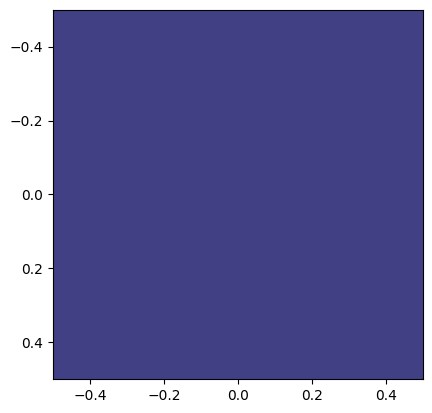

In [57]:
plt.imshow(np.array(c_x).reshape(1, 1), cmap="viridis", vmin=field.min(), vmax=field.max())

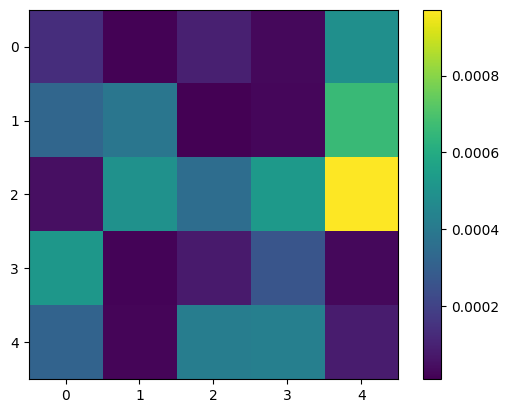

In [58]:
plt.imshow(field)
plt.colorbar()

In [66]:
np.random.seed(1312)

# create a 2D field
nx, ny = 5, 5
dx, dy = 1, 1
x = np.linspace(0, nx-1, nx)
y = np.linspace(0, ny-1, ny)
x, y = np.meshgrid(x, y)

l_c = []

for i in range(2000):
    field = 10**(np.random.rand(nx, ny)*-2 + -3)
    c_x_min = find_c(field, direction="x", first_type="series")
    c_x_max = find_c(field, direction="x", first_type="parallel")
    l_c.append((c_x_min, c_x_max))

(array([[  2.,   1.,   7.,  13.,  27.,  42.,  71.,  95., 100., 123., 164.,
         171., 177., 158., 139., 155., 132., 106.,  92.,  69.,  50.,  50.,
          24.,  17.,  11.,   2.,   1.,   0.,   1.,   0.],
        [  0.,   1.,   0.,   0.,   4.,   4.,   6.,  17.,  27.,  40.,  63.,
          82., 111., 122., 134., 141., 132., 174., 183., 136., 142., 136.,
         112.,  94.,  64.,  40.,  15.,  10.,   8.,   2.]]),
 array([-4.54648174, -4.51123014, -4.47597855, -4.44072695, -4.40547535,
        -4.37022375, -4.33497215, -4.29972055, -4.26446895, -4.22921735,
        -4.19396575, -4.15871415, -4.12346256, -4.08821096, -4.05295936,
        -4.01770776, -3.98245616, -3.94720456, -3.91195296, -3.87670136,
        -3.84144976, -3.80619816, -3.77094657, -3.73569497, -3.70044337,
        -3.66519177, -3.62994017, -3.59468857, -3.55943697, -3.52418537,
        -3.48893377]),
 <a list of 2 BarContainer objects>)

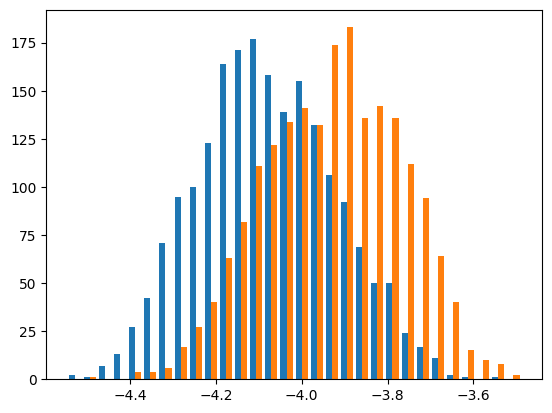

In [67]:
plt.hist(np.log10(np.array(l_c)), bins=30)

In [68]:
np.random.seed(81)
a = np.random.rand(4, 4)
print(find_c(a, direction="x", first_type="series"), find_c(a, direction="x", first_type="parallel"))

0.3642482351600886 0.4589994718936754


In [74]:
# now keq is a function of cmin and cmax according to keq = cmax**alpha*(cmin)**(1-alpha)
def get_alpha(dx, dy, dz=None, direction="x"):
    
    def f_u(t):
        return np.arctan(np.sqrt(t)) / (np.pi/2)

    if dz is None:
        if direction == "x":
            a = dx/dy
        elif direction == "y":
            a = dy/dx
        
        u = f_u(a)
        return u

    if direction == "x":
        a_1 = dx/dy
        a_2 = dx/dz
    elif direction == "y":
        a_1 = dy/dx
        a_2 = dy/dz
    elif direction == "z":
        a_1 = dz/dx
        a_2 = dz/dy
        
    u_1 = f_u(a_1)
    u_2 = f_u(a_2)

    return ((u_1 + u_2) - 2*u_1*u_2) / (1 - u_1*u_2)
    
def keq(cmin, cmax, alpha):
    return cmax**alpha*(cmin)**(1-alpha)

In [75]:
def simplified_renormalization(field, dx, dy, direction="x"):

    cx_min, cx_max = find_c(field, direction=direction, first_type="series"), find_c(field, direction=direction, first_type="parallel")
    return keq(cx_min, cx_max, get_alpha(dx, dy, direction=direction)) 


In [78]:
np.random.seed(1312)

# create a 2D field
nx, ny = 8, 8
dx, dy = 1, 1

field = 10**(np.random.rand(nx, ny)*-2 + -4)
Kxx = simplified_renormalization(field, dx, dy, direction="x")
Kyy = simplified_renormalization(field, dx, dy, direction="y")
print(np.round(Kxx, 8), np.round(Kyy, 8))

1.082e-05 1.133e-05


### Tests with an heterogeneous field

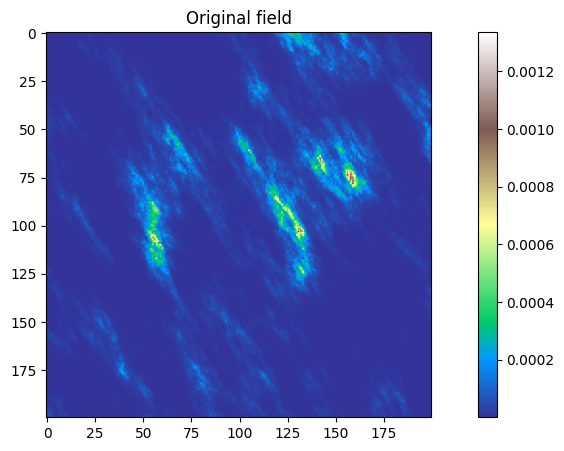

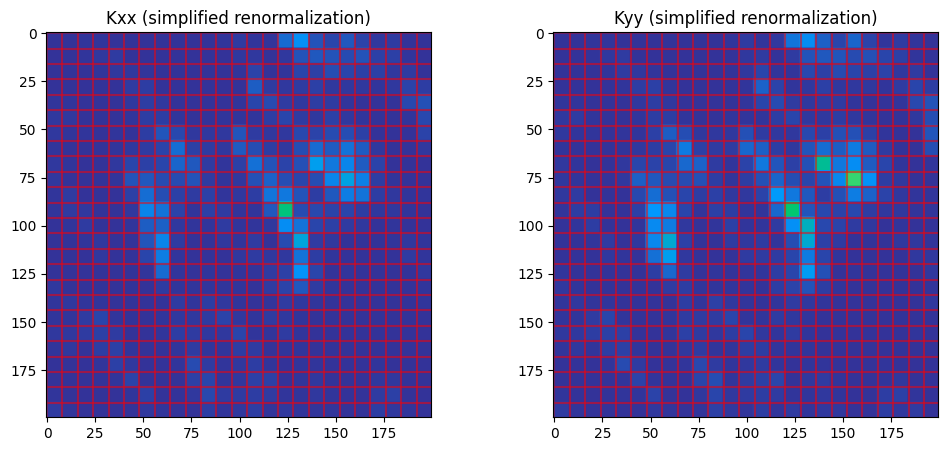

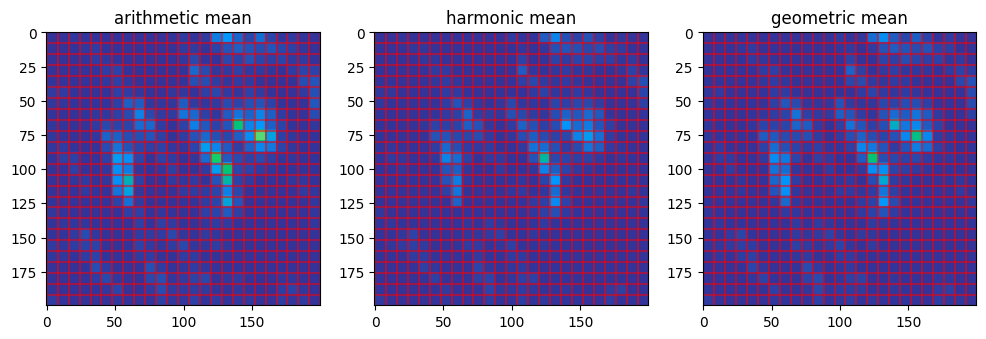

In [142]:
np.random.seed(121)

xmin = 0
xmax = 200
ymin = 0
ymax = 200
sx, sy = 8, 8

cm = geone.covModel.CovModel2D(elem=[("spherical", {"w":.5, "r":[50, 150]})
                                    ], alpha=30,
                                name="model")
nx_grid, ny_grid = 200, 200
sx_grid, sy_grid = 2, 2
field = 10**geone.multiGaussian.multiGaussianRun(cm, (nx_grid, ny_grid), (sx_grid, sy_grid), output_mode="array", mean=-5)

new_field_kxx = field[0].copy() 
new_field_kyy = field[0].copy() 

fig, ax = plt.subplots(1, 1, figsize=(12, 5))

plt.imshow(field[0], cmap="terrain", vmin=field[0].min(), vmax=field[0].max())
plt.colorbar()
plt.title("Original field")
plt.show()


fig, ax = plt.subplots(1, 2, figsize=(12, 5))
for i in range(ymin, ymax, sy):
    for j in range(xmin, xmax, sx):
        x1 = i
        lx = sx
        x2 = x1 + lx
        y1 = j
        ly = sy
        y2 = y1 + ly 
        selected_area = field[0][x1:x2, y1:y2]
        ax[0].plot([y1, y1, y2, y2, y1], [x1, x2, x2, x1, x1], color="red", alpha=.3)
        ax[1].plot([y1, y1, y2, y2, y1], [x1, x2, x2, x1, x1], color="red", alpha=.3)
        Kxx = simplified_renormalization(selected_area, dx, dy, direction="x")
        Kyy = simplified_renormalization(selected_area, dx, dy, direction="y")
        new_field_kxx[x1:x2, y1:y2] = Kxx
        new_field_kyy[x1:x2, y1:y2] = Kyy

g = ax[0].imshow(new_field_kxx, cmap="terrain", vmin=field[0].min(), vmax=field[0].max())
g = ax[1].imshow(new_field_kyy, cmap="terrain", vmin=field[0].min(), vmax=field[0].max())
ax[0].set_title("Kxx (simplified renormalization)")
ax[1].set_title("Kyy (simplified renormalization)")
plt.show()

fig, ax = plt.subplots(1, 3, figsize=(12, 5))

new_field_2_am = field[0].copy() 
new_field_2_hm = field[0].copy() 
new_field_2_gm = field[0].copy()

for i in range(ymin, ymax, sy):
    for j in range(xmin, xmax, sx):
        x1 = i
        lx = sx
        x2 = x1 + lx
        y1 = j
        ly = sy
        y2 = y1 + ly 
        selected_area = field[0][x1:x2, y1:y2]
        ax[0].plot([y1, y1, y2, y2, y1], [x1, x2, x2, x1, x1], color="red", alpha=.3)
        ax[1].plot([y1, y1, y2, y2, y1], [x1, x2, x2, x1, x1], color="red", alpha=.3)
        ax[2].plot([y1, y1, y2, y2, y1], [x1, x2, x2, x1, x1], color="red", alpha=.3)
        Kyy = np.mean(selected_area.flatten())
        Kxx = 1 / np.mean(1 / selected_area.flatten())
        Kgm = np.exp(np.mean(np.log(selected_area.flatten())))
        new_field_2_hm[x1:x2, y1:y2] = Kxx
        new_field_2_am[x1:x2, y1:y2] = Kyy
        new_field_2_gm[x1:x2, y1:y2] = Kgm

ax[0].imshow(new_field_2_am, cmap="terrain", vmin=field[0].min(), vmax=field[0].max())
ax[1].imshow(new_field_2_hm, cmap="terrain", vmin=field[0].min(), vmax=field[0].max())
ax[2].imshow(new_field_2_gm, cmap="terrain", vmin=field[0].min(), vmax=field[0].max())
ax[0].set_title("arithmetic mean")
ax[1].set_title("harmonic mean")
ax[2].set_title("geometric mean")
plt.show()

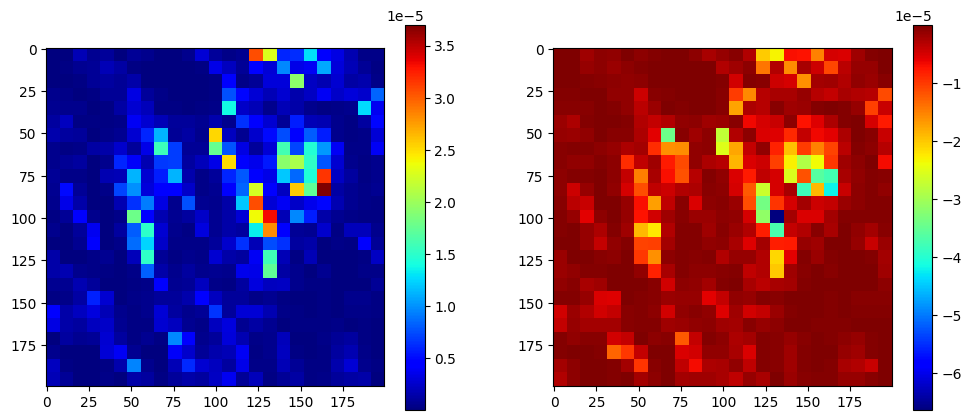

In [144]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
g = ax[0].imshow(new_field_kxx - new_field_2_hm, cmap="jet", interpolation="none")
g2 = ax[1].imshow(new_field_kyy - new_field_2_am, cmap="jet", interpolation="none")

plt.colorbar(g)
plt.colorbar(g2)
plt.show()
# plt.plot(field[0][:, 0])

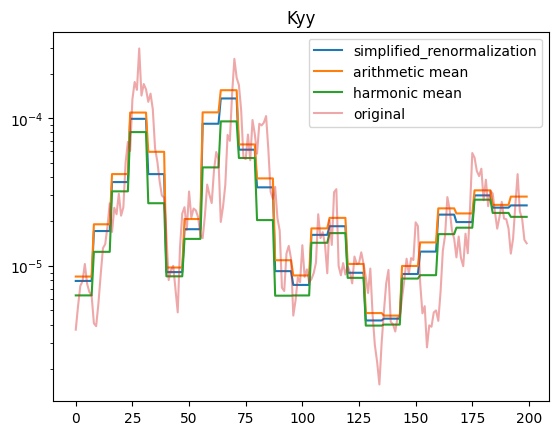

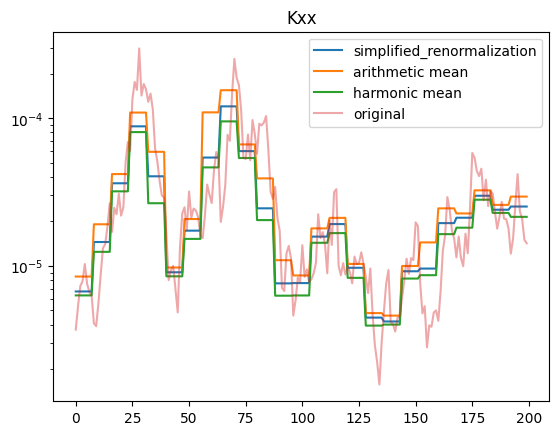

In [145]:
i = 110

plt.plot(new_field_kyy[:, i], label= "simplified_renormalization")
plt.plot(new_field_2_am[:, i], label="arithmetic mean")
plt.plot(new_field_2_hm[:, i], label="harmonic mean")
# plt.plot(new_field_2_gm[:, i], label="geometric mean")
plt.plot(field[0][:, i], label="original", alpha=.4)
plt.title("Kyy")
plt.legend()

plt.yscale("log")
plt.show()
plt.plot(new_field_kxx[:, i], label= "simplified_renormalization")
plt.plot(new_field_2_am[:, i], label="arithmetic mean")
plt.plot(new_field_2_hm[:, i], label="harmonic mean")
# plt.plot(new_field_2_gm[:, i], label="geometric mean")
plt.plot(field[0][:, i], label="original", alpha=.4)
plt.title("Kxx")
plt.legend()
plt.yscale("log")
plt.show()

In [146]:
cx_min, cx_max = find_c(selected_area, direction="x", first_type="series"), find_c(selected_area, direction="x", first_type="parallel")

In [147]:
1 / np.mean(1 / selected_area.flatten()), np.std(selected_area.flatten()), cx_min, cx_max

(1.1392134980894847e-06,
 8.425086480999828e-07,
 1.1875897262477238e-06,
 1.2162862145622284e-06)

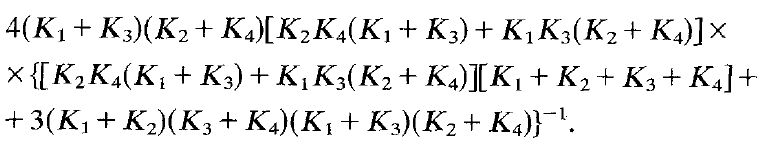

In [187]:
@jit
def f_sr(block):

    """
    Standard renormalization in 2D from King (1989).
    Takes a block of size 2X2 as input and output equivalent permeability
    """

    K1 = block[0, 0]
    K2 = block[0, 1]
    K3 = block[1, 0]
    K4 = block[1, 1]

    a = 4*(K1 + K3) * (K2 + K4)
    b = (K2 * K4 * (K1 + K3) + K1 * K3 * (K2 + K4))
    c = b*(K1 + K2 + K3 + K4) + 3 * (K1 + K2) * (K3 + K4) * (K1 + K3) * (K2 + K4)
    Kxx = a * b * (1/c)

    return Kxx

# def f_sr_keq(block):

#     Keq = np.zeros((2, 2))
#     Keq[0, 0] = f_sr(block)
#     Keq[1, 1] = f_sr(block.T)
#     return Keq

def standard_renormalization(field, direction="x"):
    
    # assert that field is 2**n
    assert field.shape[0] == field.shape[1]
    assert np.log2(field.shape[0]).is_integer(), "Field size must be a power of 2"

    def one_iteration(field):
        new_field = np.zeros((field.shape[0]//2, field.shape[1]//2))
        for i in range(0, field.shape[0], 2):
            for j in range(0, field.shape[1], 2):
                block = field[i:i+2, j:j+2]
                if direction == "x":
                    new_field[i//2, j//2] = f_sr(block)
                elif direction == "y":
                    new_field[i//2, j//2] = f_sr(block.T)
        
        return new_field

    list_field = [field]
    while field.shape[0] > 1:
        field = one_iteration(field)
        list_field.append(field)

    return list_field

In [223]:
nx, ny = 16, 16
dx, dy = 1, 1

field = 10**(np.random.rand(nx, ny)*-2 + -4)
Kxx = standard_renormalization(field, direction="x")
Kyy = standard_renormalization(field, direction="y")

In [224]:
%%timeit
standard_renormalization(field, direction="x")
standard_renormalization(field, direction="y")

273 μs ± 47 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [225]:
%%timeit
simplified_renormalization(field, dx, dy, direction="x")
simplified_renormalization(field, dx, dy, direction="y")

376 μs ± 36.8 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


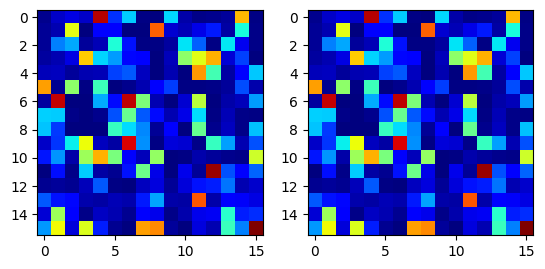

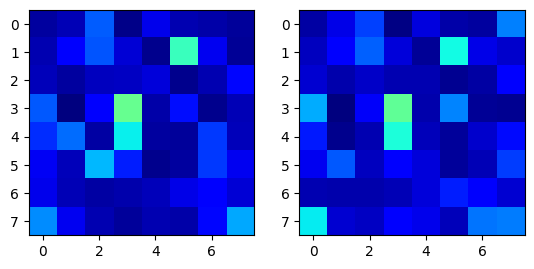

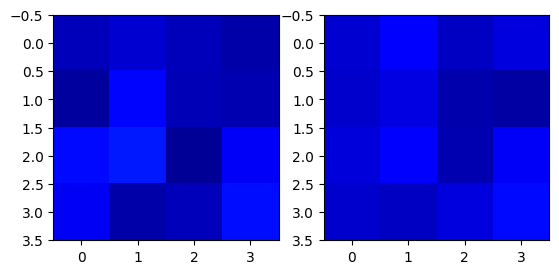

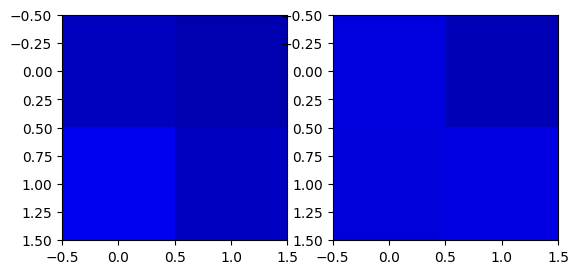

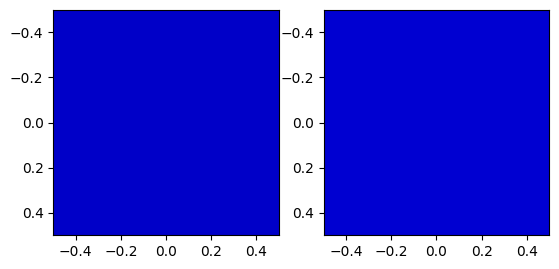

In [226]:
for arrx, arry in zip(Kxx, Kyy):
    plt.subplot(1, 2, 1)
    plt.imshow(arrx, cmap="jet", vmin=field.min(), vmax=field.max())
    # plt.colorbar()
    plt.subplot(1, 2, 2)
    plt.imshow(arry, cmap="jet", vmin=field.min(), vmax=field.max())
    # plt.colorbar()
    plt.show()

In [227]:
simplified_renormalization(field, dx, dy, direction="x"), simplified_renormalization(field, dx, dy, direction="y")

(8.055890633855716e-06, 9.133435907649048e-06)

In [228]:
Kxx[-1][0, 0], Kyy[-1][0, 0]

(7.232989188922565e-06, 8.23994508045855e-06)

In [229]:
def f_tr(Kxx, Kyy, Kxy):

    """
    Tensorial renormalization in 2D from Gautier and Noetinger (1997)
    Takes three blocks of size 2X2 as input and output equivalent permeability
    each block corresponds to a part of the hydraulic conductivity tensor (symmetric)
    """

    k1xx = Kxx[0, 0]
    k2xx = Kxx[0, 1]
    k3xx = Kxx[1, 0]
    k4xx = Kxx[1, 1]

    k1yy = Kyy[0, 0]
    k2yy = Kyy[0, 1]
    k3yy = Kyy[1, 0]
    k4yy = Kyy[1, 1]

    k1xy = Kxy[0, 0]
    k2xy = Kxy[0, 1]
    k3xy = Kxy[1, 0]
    k4xy = Kxy[1, 1]

    # building system of equations
    A = np.array(
        [
            [k1xx + k2xx + k1yy + k3yy + 2 * k1xy, -(k1xx + k2xx + k1xy + k2xy)        , -(k1yy + k3yy + k1xy + k3xy)],
            [-(k1xx + k2xx + k1xy + k2xy)        , k1xx + k4yy + k2xx + 2 * k2xy + k2yy, k1xy + k4xy],
            [-(k1yy + k3yy + k1xy + k3xy)        , k1xy + k4xy                         , k1yy + k4xx + k3xx + 2 * k3xy + k3yy]
        ]
                )

    b = np.array(
        [
            [k2xx              , k3yy], 
            [k4xy - k2xx - k2xy, k4yy],
            [k4xx              , k4xy - k3xy - k3yy]
        ]
                )

    # determine Keq
    Keq = np.zeros((2, 2))
    DeltaHx = 1
    DeltaHy = 0
    DH = np.array([[DeltaHx, DeltaHy]])

    h = np.linalg.solve(A, np.dot(b, DH.T))
    # Ux = (k3xy - k1xx - k1xy) * h[0] + h[1]*k1xx + (k3xx + k3xy) * h[2] - k3xy * DeltaHy
    # Uy = (k2xy - k1yy - k1xy) * h[0] + (k1xy - k2yy - k2xy) * h[1] + k1yy * h[2] - k2xy * DeltaHx
    Ux = (k1xx * (h[0] - h[1]) + k3xx * h[2] + k1xy * (h[0] - h[2]) + k3xy * (h[2] - (h[0] - DeltaHy)))
    Uy = (k1yy * (h[0] - h[2]) + k2yy * h[1] + k1xy * (h[0] - h[1]) + k2xy * (h[1] - (h[0] - DeltaHx)))

    Keq[0, 0] = Ux[0]
    Keq[0, 1] = Uy[0]

    DeltaHx = 0
    DeltaHy = 1
    DH = np.array([[DeltaHx, DeltaHy]])

    h = np.linalg.solve(A, np.dot(b, DH.T))
    # Ux = (k3xy - k1xx - k1xy) * h[0] + h[1]*k1xx - (k3xx + k3xy) * h[2] - k3xy * DeltaHy
    # Uy = (k2xy - k1yy - k1xy) * h[0] + (k1xy - k2yy - k2xy) * h[1] + k1yy * h[2] - k2xy * DeltaHx
    Ux = (k1xx * (h[0] - h[1]) + k3xx * h[2] + k1xy * (h[0] - h[2]) + k3xy * (h[2] - (h[0] - DeltaHy)))
    Uy = (k1yy * (h[0] - h[2]) + k2yy * h[1] + k1xy * (h[0] - h[1]) + k2xy * (h[1] - (h[0] - DeltaHx)))

    Keq[1, 0] = Ux[0]
    Keq[1, 1] = Uy[0]

    return Keq

In [230]:
def tensorial_renormalization(field_kxx, field_kyy, field_kxy):

    # assert that field is 2**n
    assert field_kxx.shape[0] == field_kxx.shape[1]
    assert np.log2(field_kxx.shape[0]).is_integer(), "Field size must be a power of 2"

    def one_iteration(field_kxx, field_kyy, field_kxy):
        new_field_kxx = np.zeros((field_kxx.shape[0]//2, field_kxx.shape[1]//2))
        new_field_kyy = np.zeros((field_kyy.shape[0]//2, field_kyy.shape[1]//2))
        new_field_kxy = np.zeros((field_kxy.shape[0]//2, field_kxy.shape[1]//2))
        for i in range(0, field_kxx.shape[0], 2):
            for j in range(0, field_kxx.shape[1], 2):
                block_kxx = field_kxx[i:i+2, j:j+2]
                block_kyy = field_kyy[i:i+2, j:j+2]
                block_kxy = field_kxy[i:i+2, j:j+2]
                keq = f_tr(block_kxx, block_kyy, block_kxy)
                new_field_kxx[i//2, j//2] = keq[0, 0]
                new_field_kyy[i//2, j//2] = keq[1, 1]
                new_field_kxy[i//2, j//2] = keq[0, 1]
        
        return new_field_kxx, new_field_kyy, new_field_kxy

    list_field_kxx = [field_kxx]
    list_field_kyy = [field_kyy]
    list_field_kxy = [field_kxy]
    while field_kxx.shape[0] > 1:
        field_kxx, field_kyy, field_kxy = one_iteration(field_kxx, field_kyy, field_kxy)
        list_field_kxx.append(field_kxx)
        list_field_kyy.append(field_kyy)
        list_field_kxy.append(field_kxy)

    return list_field_kxx, list_field_kyy, list_field_kxy

In [231]:
list_field_kxx, list_field_kyy, list_field_kxy = tensorial_renormalization(field, field, np.zeros((nx, ny)))

In [232]:
list_field_kxx[-1][0, 0], list_field_kyy[-1][0, 0]

(8.079274507551906e-06, 9.26034449264756e-06)

In [ ]:
# TO DO
def upscaling():
    pass